In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.data import Dataset

# Paths
IMAGE_DIR = "C:/Users/COMPUTER POINT/Downloads/Constellation Datasest/labels"
LABELS_FILE = "C:/Users/COMPUTER POINT/Downloads/Constellation Datasest/constellation names.txt"
OUTPUT_DIR = 'augmented_dataset/'
NUM_AUGMENTED = 50
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32



## Creating and proper formatting the dataset

In [7]:


def parse_labels(labels_file):
    label_map = {}
    with open(labels_file, 'r') as file:
        for line in file:

            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                number, label = parts
                label_map[int(number)] = label
            else:
                print(f"Skipping invalid line: {line}")
    return label_map

In [16]:
label_map = parse_labels(LABELS_FILE)
import pandas as pd

output_file = "label_map.txt"

# Save the label map to the file
with open(output_file, "w") as file:
    for index, label in label_map.items():
        file.write(f"{index}: {label}\n")

print(f"Label map saved to {output_file}")


Skipping invalid line: 

Skipping invalid line: 

Label map saved to label_map.txt


In [9]:

def augment_dataset(image_dir, labels, output_dir, num_augmented):
    os.makedirs(output_dir, exist_ok=True)
    datagen = ImageDataGenerator(

        rotation_range=360,

    )

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        label = labels[int(os.path.splitext(img_name)[0])]
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=label_dir, save_prefix='aug', save_format='png'):
            i += 1
            if i >= num_augmented:
                break




In [4]:


def load_dataset(data_dir, image_size, batch_size):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator


In [6]:
train_generator , val_generator = load_dataset(IMAGE_DIR, IMAGE_SIZE, BATCH_SIZE)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


{}

In [11]:


def create_and_load_dataset():
    label_map = parse_labels(LABELS_FILE)

    augment_dataset(IMAGE_DIR, label_map, OUTPUT_DIR, NUM_AUGMENTED)

    train_data, val_data = load_dataset(OUTPUT_DIR, IMAGE_SIZE, BATCH_SIZE)

    return train_data, val_data


if __name__ == "__main__":
    train_generator, val_generator = create_and_load_dataset()

    print("Class Indices:", train_generator.class_indices)


Skipping invalid line: 

Skipping invalid line: 



KeyboardInterrupt: 

## Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (256, 256, 3)


def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model



In [18]:
model = create_cnn(input_shape, 86)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


Epoch 1/20
108/108 [==============================] - 126s 826ms/step - loss: 4.2631 - accuracy: 0.0285 - val_loss: 3.9449 - val_accuracy: 0.0530
Epoch 2/20
108/108 [==============================] - 83s 767ms/step - loss: 3.8674 - accuracy: 0.0622 - val_loss: 3.4985 - val_accuracy: 0.1225
Epoch 3/20
108/108 [==============================] - 82s 763ms/step - loss: 3.4007 - accuracy: 0.1381 - val_loss: 2.8736 - val_accuracy: 0.2591
Epoch 4/20
108/108 [==============================] - 82s 758ms/step - loss: 2.9322 - accuracy: 0.2250 - val_loss: 2.5448 - val_accuracy: 0.3239
Epoch 5/20
108/108 [==============================] - 96s 884ms/step - loss: 2.5898 - accuracy: 0.2971 - val_loss: 2.2734 - val_accuracy: 0.4099
Epoch 6/20
108/108 [==============================] - 99s 920ms/step - loss: 2.2630 - accuracy: 0.3738 - val_loss: 2.0542 - val_accuracy: 0.4452
Epoch 7/20
108/108 [==============================] - 82s 761ms/step - loss: 1.9562 - accuracy: 0.4544 - val_loss: 1.8076 - val_a

## Plotting Results

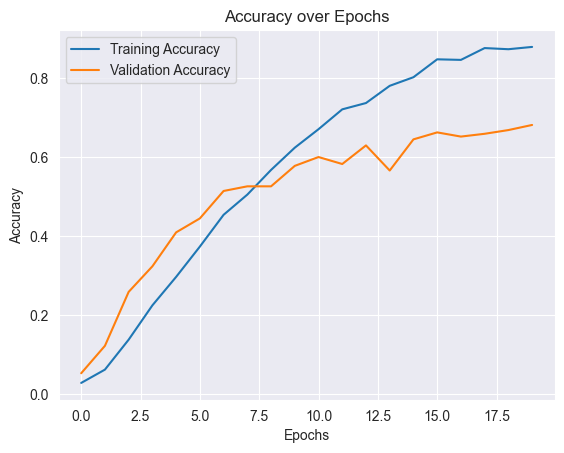

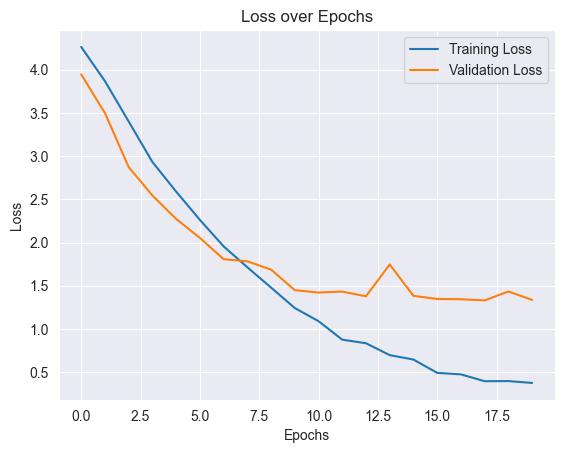

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [20]:
model.save('constellation_classifier.h5')

In [18]:
from tensorflow.keras.models import load_model

model = load_model('constellation_classifier.h5')

In [24]:
label_map

{1: 'vela',
 2: 'musca',
 3: 'Grus',
 4: 'Canis minor',
 5: 'cancer',
 6: 'Leo',
 7: 'Leo minor',
 8: 'ursa minor',
 9: 'lyra',
 10: 'dorado',
 11: 'Scorpius',
 12: 'Cepheus',
 13: 'Virgo',
 14: 'Ursa major',
 15: 'Perceus',
 16: 'Canis major',
 17: 'Lepus',
 18: 'Columba',
 19: 'Aquarius',
 20: 'Capricornus',
 21: 'Gemini',
 22: 'Pictor',
 23: 'Puppis',
 24: 'Mensa',
 25: 'Reticulum',
 26: 'Volans',
 27: 'Bootes',
 28: 'Lacerta',
 29: 'fornax',
 30: 'Hydrus',
 31: 'Octans',
 32: 'Pavo',
 33: 'lupus',
 34: 'Orion',
 35: 'Cetus',
 36: 'sextan',
 37: 'Aquila',
 38: 'Microscopium',
 39: 'Indus',
 40: 'Ara',
 41: 'Corona Australis',
 42: 'Libra',
 43: 'Sagittarius',
 44: 'Aries',
 45: 'Corona Borealis',
 46: 'Sculptor',
 47: 'Phoenix',
 48: 'Horologium',
 49: 'Caelum',
 50: 'Tucana',
 51: 'Chameleon',
 52: 'Crux',
 53: 'Monoceros',
 54: 'Taurus',
 55: 'Crater',
 56: 'Corvus',
 57: 'Circinus',
 58: 'Triangulum',
 59: 'Cassiopeia',
 60: 'Cygnus',
 61: 'Camelopardalis',
 62: 'Coma Berenices',

In [29]:
import numpy as np
def predict_image(model, image_path, label_map):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)

        # Debugging outputs
        print(f"Predicted class index: {predicted_class}")


        # Get the label from the label map
        if predicted_class not in label_map:
            raise KeyError(f"Predicted class index {predicted_class} not found in label map.")

        predicted_label = label_map[predicted_class]
        return predicted_label, predictions
    except KeyError as e:
        print(f"KeyError: {e}")
        return None, None
    except Exception as e:
        print(f"Error: {e}")
        return None, None


test_image_path = "{B1FFD70A-8009-41F4-8222-60EFC2A1D510}.png"

predicted_label, probabilities = predict_image(model, test_image_path, label_map)

if predicted_label:
    print(f"Predicted Label: {predicted_label}")

else:
    print("Prediction failed.")



1/1 [==============================] - 0s 18ms/step
Predicted class index: 67
Predicted Label: Delphinus
